In [1]:
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 67.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=b98ddd82bec7823188a5e0291e65beee03345b1204e5526a2b2e8b7e7617ee5b
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize-matplotlib


In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
import cv2
%matplotlib inline

In [3]:
TrainImg_DIR = '/content/drive/MyDrive/university/seminar/chuzo-pj/datasets/train_data/train_data/'
TestImg_DIR = '/content/drive/MyDrive/university/seminar/chuzo-pj/datasets/test_data/test_data/'

train_csv = pd.read_csv('/content/drive/MyDrive/university/seminar/chuzo-pj/datasets/train.csv')
train_csv = train_csv.sort_values(by=['id'])

sampleSubmit_csv = pd.read_csv('/content/drive/MyDrive/university/seminar/chuzo-pj/datasets/sample_submission.csv', header=None)
sampleSubmit_csv.columns = [['id', 'preds']]

x_train = np.array(train_csv['id'])
t_train = np.array(train_csv['target'])
x_test = np.array(sampleSubmit_csv['id']).flatten()

In [86]:
height = 224
width = 224
lr = 1e-4
n_epochs = 500
batch_size = 20
val_ratio = 0.2

In [74]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data in dataloader:# dataloader_trainを使うときは"for data, _ in dataloader:"に書き換えないといけない
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [75]:
#各チャンネルごとの平均値と標準偏差を求める
#mean, std = get_mean_and_std(dataloader_test)
#print(mean)
#print(std)

In [76]:
class train_dataset(torch.utils.data.Dataset):
  def __init__(self, x_train, t_train, transform):
    self.x_train = x_train
    self.t_train = t_train.astype("int32")
    self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self, idx):
    image = Image.open(TrainImg_DIR+self.x_train[idx])
    data = torch.tensor(np.array(image), dtype=torch.float)
    data = torch.transpose(data, 0, 2)
    data = torch.transpose(data, 1, 2)
    label = torch.tensor(self.t_train[idx], dtype=torch.float)
    if self.transform:
      data = self.transform(data)
      return data, label
  
class test_dataset(torch.utils.data.Dataset):
  def __init__(self, x_test, transform):
    self.x_test = x_test
    self.transform = transform
  
  def __len__(self):
    return len(self.x_test)
  
  def __getitem__(self, idx):
    image = Image.open(TestImg_DIR+self.x_test[idx])
    data = torch.tensor(np.array(image), dtype=torch.float)
    data = torch.transpose(data, 0, 2)
    data = torch.transpose(data, 1, 2)
    if self.transform:
      data = self.transform(data)
      return data

In [77]:
#前処理の定義
transform_train = transforms.Compose([])
transform_test = transforms.Compose([])

transform_train = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=10, expand=True),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.4834, 0.4834, 0.4834),
                             (0.2892, 0.2892, 0.2892)),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.4834, 0.4834, 0.4834),
                             (0.2892, 0.2892, 0.2892)),
    ]
)

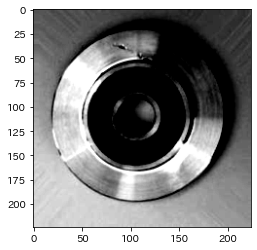

In [78]:
# 前処理した画像の例
img_path = TrainImg_DIR + 'cast_def_0_107.jpeg'
img = Image.open(img_path)

img_np = np.array(img)

transform_norm = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
    transforms.Normalize((0.4834, 0.4834, 0.4834),
                          (0.2892, 0.2892, 0.2892)),
])

img_normalized = transform_norm(img)

img_normalized = np.array(img_normalized)
img_normalized = img_normalized.transpose(1, 2, 0)
plt.imshow(img_normalized)

In [79]:
# データセットインスタンスの作成
trainval_data = train_dataset(x_train, t_train, transform_train)
test_data = test_dataset(x_test, transform_test)

# 学習用データと検証用データを分割
val_size = int(len(trainval_data) * val_ratio)
train_size = len(trainval_data) - val_size
train_data, val_data = torch.utils.data.random_split(
    trainval_data, [train_size, val_size]
)

In [80]:
#dataloaderインスタンス作成
dataloader_train = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size, shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)

rng = np.random.RandomState(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='checkpoint_model.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する

In [82]:
class GAP(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return F.adaptive_avg_pool2d(x, (1, 1)).squeeze()


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)

In [87]:
model_tuned = models.vgg16(pretrained=True)

for param in model_tuned.parameters():
        param.requires_grad = False

model_tuned.avgpool = GAP()
in_dim = 512
out_dim = 1
model_tuned.classifier = nn.Sequential(
    nn.Linear(in_dim, 256),
    nn.ReLU(True),
    nn.Dropout(p=0.2),
    nn.Linear(256, 64),
    nn.ReLU(True),
    nn.Dropout(p=0.2),
    nn.Linear(64, out_dim),
    nn.Sigmoid(),
)
#model_tuned.classifier.apply(init_weights)
model_tuned.to(device)
#model_tuned.load_state_dict(torch.load('/content/drive/MyDrive/university/seminar/chuzo-pj/ws/models/checkpoint_model.pth', map_location=torch.device(device)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [88]:
from torchsummary import summary
summary(model_tuned, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [89]:
optimizer_tuned = optim.AdamW(model_tuned.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_tuned, T_0=20)
loss_function = nn.BCELoss()
earlystopping = EarlyStopping(patience=10, verbose=True)
losses_train = []
losses_valid = []
accs_train = []
accs_valid = []
for epoch in range(n_epochs):
  
  running_train_losses = []
  running_valid_losses = []

  model_tuned.train()
  n_train = 0
  acc_train = 0
  for x, t in dataloader_train:
    n_train += t.size()[0]

    model_tuned.zero_grad()

    x = x.to(device)
    t = t.to(device)
    
    y = model_tuned.forward(x)
    y = torch.squeeze(y)

    loss = loss_function(y, t)

    loss.backward()

    optimizer_tuned.step()

    #pred = torch.tensor(np.where(y>=0.5, 1, 0))
    pred = (y>=0.5).float()

    acc_train += (pred == t).float().sum().item()
    running_train_losses.append(loss.tolist())

  model_tuned.eval()
  n_val = 0
  acc_val = 0
  for x, t in dataloader_valid:
    n_val += t.size()[0]

    x = x.to(device)
    t = t.to(device)

    y = model_tuned.forward(x)
    y = torch.squeeze(y)

    loss = loss_function(y, t)

    #pred = torch.tensor(np.where(y>=0.5, 1, 0))
    pred = (y>=0.5).float()
    acc_val += (pred == t).float().sum().item()
    running_valid_losses.append(loss.tolist())

  # scheduler.step()
  print(
      "EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]".format(
            epoch,
            np.mean(running_train_losses),
            acc_train / n_train,
            np.mean(running_valid_losses),
            acc_val / n_val,
      )
  )
  accs_train.append(acc_train/n_train)
  accs_valid.append(acc_val/n_val)
  losses_train.append(np.mean(running_train_losses))
  losses_valid.append(np.mean(running_valid_losses))

  earlystopping((np.mean(running_valid_losses)), model_tuned)
  if earlystopping.early_stop:
    print("Early Stopping!")
    break

EPOCH: 0, Train [Loss: 0.687, Accuracy: 0.570], Valid [Loss: 0.675, Accuracy: 0.620]
Validation loss decreased (inf --> 0.675497).  Saving model ...
EPOCH: 1, Train [Loss: 0.681, Accuracy: 0.595], Valid [Loss: 0.673, Accuracy: 0.620]
Validation loss decreased (0.675497 --> 0.672953).  Saving model ...
EPOCH: 2, Train [Loss: 0.678, Accuracy: 0.595], Valid [Loss: 0.665, Accuracy: 0.620]
Validation loss decreased (0.672953 --> 0.665310).  Saving model ...
EPOCH: 3, Train [Loss: 0.674, Accuracy: 0.595], Valid [Loss: 0.661, Accuracy: 0.620]
Validation loss decreased (0.665310 --> 0.661330).  Saving model ...
EPOCH: 4, Train [Loss: 0.669, Accuracy: 0.595], Valid [Loss: 0.660, Accuracy: 0.620]
Validation loss decreased (0.661330 --> 0.659905).  Saving model ...
EPOCH: 5, Train [Loss: 0.672, Accuracy: 0.595], Valid [Loss: 0.672, Accuracy: 0.620]
EarlyStopping counter: 1 out of 10
EPOCH: 6, Train [Loss: 0.667, Accuracy: 0.595], Valid [Loss: 0.647, Accuracy: 0.620]
Validation loss decreased (0.6

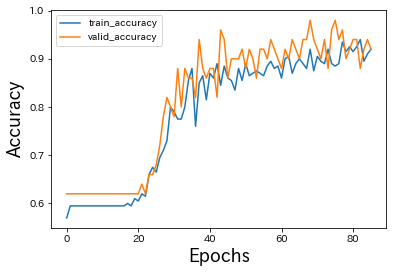

In [90]:
plt.plot(accs_train, label="train_accuracy")
plt.plot(accs_valid, label="valid_accuracy")
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()
plt.savefig('pretrainTrue_accuracy_curve.png')
plt.show()

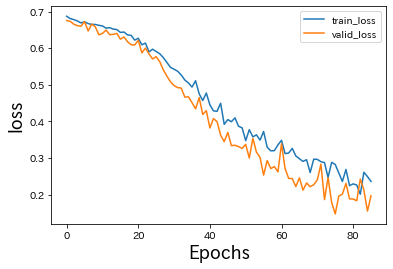

In [91]:
plt.plot(losses_train, label="train_loss")
plt.plot(losses_valid, label="valid_loss")
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.legend()
plt.savefig('pretraTrue_loss_curve.png')
plt.show()

In [95]:
model_tuned.load_state_dict(torch.load('/content/checkpoint_model.pth', map_location=torch.device(device)))
model_tuned.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#model_tuned.load_state_dict(torch.load('/content/checkpoint_model.pth', map_location=torch.device(device)))
model_tuned.eval()

t_preds = []
for x in dataloader_test:
  x = x.to(device)
  output = model_tuned(x)
  pred = torch.squeeze((output>=0.5).float().int()).to('cpu').numpy()
  t_preds.extend(pred)

In [ ]:
submission = pd.DataFrame({"id": x_test, "pred": t_preds})
submission.head()

In [ ]:
# submission.to_csv('/content/drive/MyDrive/university/seminar/chuzo-pj/outputs/Jun4_vgg16_gap_input300_valLoss00359_auc100.csv', index=None, header=None)

In [96]:
Probs_valid = []

In [97]:
from sklearn.metrics import confusion_matrix

In [98]:
check_data = train_dataset(x_train, t_train, transform_test)
_, check_data = torch.utils.data.random_split(
    check_data, [train_size, val_size]
)

In [105]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [111]:
%%time
def tentap2list(tentap):
  """
  予測確率と勾配がタプルに格納されているリストから予測確率だけをリストに格納する関数
  """
  probas_list = [tentap[i].item() for i in range(len(tentap))]
  return probas_list

for i in range(1):
  #dataloader_check = torch.utils.data.DataLoader(
  #  check_data, batch_size=batch_size, shuffle=True
  #)

  target = []
  probas = []
  for x, t in dataloader_valid:
    x = x.to(device)
    t = t.to(device)
    print(len(t))
    start.record()
    %time y = model_tuned.forward(x)
    end.record()
    torch.cuda.synchronize()
    elapsed_time = start.elapsed_time(end)
    print(elapsed_time / 1000, 'ms.')
    y = torch.squeeze(y)

    target += t
    probas += y

  print(f"probas' length: {len(probas)}\ntarget's length: {len(target)}")
  
  probas_list = tentap2list(probas)
  targets_list = tentap2list(target)
 
  targets_arr = np.array(targets_list)
  probas_arr = np.array(probas_list)

  probas_list = [round(probas_list[i], 4) for i in range(len(probas_list))]

  preds = np.where(probas_arr>=0.5, 1.0, 0.0)
  print(confusion_matrix(targets_list, preds))

  Probs_valid.extend(probas_list)

20
CPU times: user 3.45 ms, sys: 275 µs, total: 3.73 ms
Wall time: 3.24 ms
0.15312559509277343 ms.
20
CPU times: user 2.82 ms, sys: 0 ns, total: 2.82 ms
Wall time: 2.49 ms
0.15055894470214845 ms.
10
CPU times: user 3.4 ms, sys: 240 µs, total: 3.64 ms
Wall time: 4.99 ms
0.054457439422607425 ms.
probas' length: 50
target's length: 50
[[31  0]
 [ 0 19]]
CPU times: user 673 ms, sys: 465 ms, total: 1.14 s
Wall time: 1.19 s


Sat Jan 14 12:25:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    28W /  70W |   5238MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# data = pd.DataFrame({'pred':probas_list, 'true':targets_list})
# data.head()

In [ ]:
# data.to_csv('/content/drive/MyDrive/university/seminar/chuzo-pj/outputs/valData50_preds.csv', index=None, header=None)

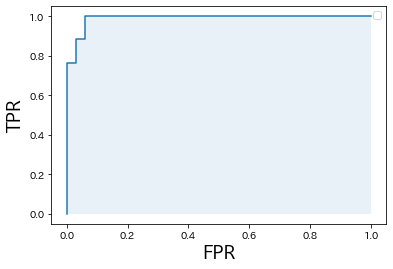

AUC: 0.9893


In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
targets_arr = np.array(targets_list)
probas_arr = np.array(probas_list)
fpr, tpr, thresholds = roc_curve(y_true=targets_arr, y_score=probas_arr, pos_label=1)
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, 0, alpha=0.1)

plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.legend()
# plt.savefig('/content/drive/MyDrive/university/seminar/chuzo-pj/outputs/roc_curve.png')
plt.show()
print(f'AUC: {roc_auc_score(targets_list, probas_list):.4f}')

In [ ]:
len(Probs_valid)

250

In [ ]:
np.save('Probs_valid_500.npy', Probs_valid)

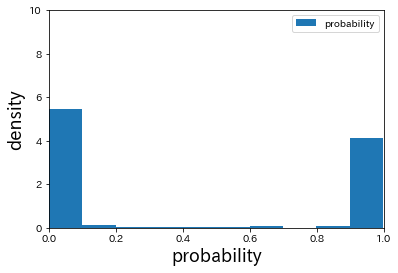

In [ ]:
data = np.sort(Probs_valid)[::-1]
fig, ax = plt.subplots()
ax.hist(data, density=True, label='probability')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 10)
ax.set_xlabel('probability', fontsize=18)
ax.set_ylabel('density', fontsize=18)
plt.savefig('/content/drive/MyDrive/university/seminar/chuzo-pj/outputs/prob_dense_5timesOfInferences.png')
plt.show()

In [ ]:
ProbsOfPos = [Probs_valid[i] for i in range(len(Probs_valid)) if Probs_valid[i] >= 0.5]
ProbsOfNeg = [Probs_valid[i] for i in range(len(Probs_valid)) if Probs_valid[i] < 0.5]

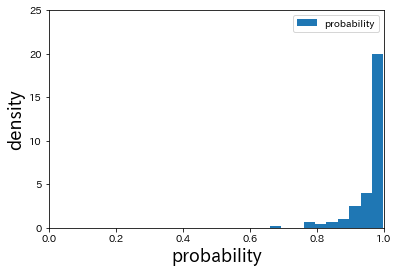

In [ ]:
data = np.sort(ProbsOfPos)[::-1]
fig, ax = plt.subplots()
ax.hist(data, density=True, label='probability')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('probability', fontsize=18)
ax.set_ylabel('density', fontsize=18)
plt.show()

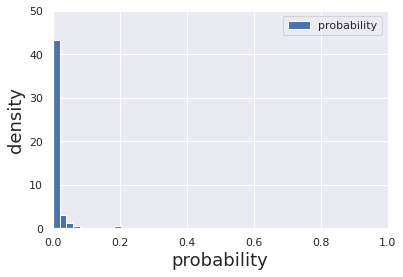

In [ ]:
data = np.sort(ProbsOfNeg)[::-1]
fig, ax = plt.subplots()
ax.hist(data, density=True, label='probability')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 50)
ax.set_xlabel('probability', fontsize=18)
ax.set_ylabel('density', fontsize=18)
plt.show()

In [ ]:
from scipy import stats
import seaborn as sns
sns.set()

c_list = sns.color_palette().as_hex()
color_num = len(c_list)

In [ ]:
from sklearn.neighbors import KernelDensity
Probs_valid_arr = np.array(Probs_valid).reshape(len(Probs_valid),1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.8).fit(Probs_valid_arr)

In [ ]:
x_min = 0
x_max = 1
x = np.arange(x_min, x_max+0.1, 0.1)
x = x.reshape(x.shape[0], 1) # n行1列の行列に変形
 
# 密度関数を推定する（対数で得られる）
log_density = kde.score_samples(x)

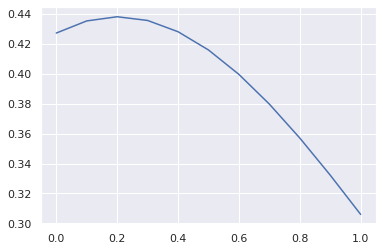

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(x, np.exp(log_density))
plt.savefig('kde-08.png', dpi=300, facecolor='white')
plt.show()

In [ ]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(targets_arr, probas_arr, n_bins=5)
print(f"Probability of True: {prob_true}")
print(f"Probability of Prediction: {prob_pred}")

Probability of True: [0. 1.]
Probability of Prediction: [0.00650357 0.97769545]


In [ ]:
def PlotGradCam(model, img_path):
  features = model.features.eval()
  avgpool = model.avgpool.eval()
  classifier = model.classifier.eval()
  
  normalize = transforms.Normalize(
      mean=[0.4834, 0.4834, 0.4834],
      std=[0.2892, 0.2892, 0.2892])

  preprocess = transforms.Compose([
      transforms.Resize(300),
      transforms.CenterCrop(300),
      transforms.ToTensor(),
      normalize
  ])
  img = Image.open(img_path)
  img_tensor = preprocess(img)

  feature = features(img_tensor.view(-1,3,300,300))
  feature = feature.clone().detach().requires_grad_(True)

  pooled = avgpool(feature)

  y_pred = classifier(pooled.view(-1, 512))
  pred_index = torch.argmax(y_pred)
  y_pred[0][pred_index].backward()

  feature_vec = feature.grad.view(512, 9*9)
  feature = feature.squeeze(0)
  alpha = torch.mean(feature_vec, axis=1)

  L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0))
  L = L.detach().numpy()

  L_min = np.min(L)
  L_max = np.max(L - L_min)
  L = (L - L_min) / L_max

  # 元画像と同じサイズにリサイズする
  L = cv2.resize(L, (300, 300))

  # heat map に変換
  def toHeatmap(x):
      x = (x*255).reshape(-1)
      cm = plt.get_cmap('jet')
      x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
      return x.reshape(300,300,3)

  img2 = toHeatmap(L)
  img1 = img_tensor.squeeze(0).permute(1,2,0)

  alpha = 0.5
  grad_cam_image = img1*alpha + img2*(1-alpha)

  plt.imshow(grad_cam_image)
  #plt.savefig('def_133_scratch.png')

In [ ]:
model_tuned = models.vgg16(pretrained=True)
model_tuned.avgpool = GAP()
in_dim = 512
out_dim = 1
model_tuned.classifier = nn.Sequential(
    nn.BatchNorm1d(in_dim),
    nn.Linear(in_dim, 256),
    nn.ReLU(True),
    nn.Dropout(p=0.2),
    nn.Linear(256, 64),
    nn.ReLU(True),
    nn.Dropout(p=0.2),
    nn.Linear(64, out_dim),
    nn.Sigmoid(),
)
model_tuned.classifier.apply(init_weights)
model_tuned.to('cpu')
model_tuned.load_state_dict(torch.load('/content/Jun4_vgg16_gap_input300_valLoss00359_auc100.pth', map_location=torch.device('cpu')))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

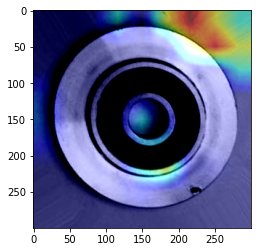

In [ ]:
img_path = TrainImg_DIR + 'cast_def_0_133.jpeg'
PlotGradCam(model_tuned, img_path)

In [ ]:
# https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

from torchvision.models import vgg16

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg16(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:2]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.vgg.avgpool = GAP()
        
        # get the classifier of the vgg19
        self.vgg.classifier = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(p=0.2),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)